# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Comics Characters on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Comic Book Characters Network
* Properties of the network structure, including how univere-origin and other properties shape the network

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into [Section 9.4](http://networksciencebook.com/chapter/9#modularity) in the exercises below. We will also talk a little bit about degree correlations - you can read about those in [Chapter 7](http://networksciencebook.com/chapter/7)\.

---
# Part A: Let's  visualise!

*Exercise 1*: Build the right graph for visualization. 

We will continue to work with the network from last week, see the lecture for [Week 4](https://nbviewer.jupyter.org/github/socialcomplexitylab/socialgraphs2022/blob/master/lectures/Week4.ipynb) for details. 

This is important! Actually, in order to continue with the lecture, you *need* to complete Week 4:

>1. Use NetworkX `DiGraph` to store the network of characters. Remember that characters are linked if they have a corresponding link between their Wikipedia pages. 
>   * **Additionally**, extract the largest component - it will make our work with visualisations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: You probably have the right graph if you have more than 2k nodes and more than 15k edges.
>     - *Note 2*: For directed graphs use `weakly connected component` to extract the largest component.
>     - *Note 3*: Further analysis is done with the largest component
>2. As you build the graph, store the attributes of the nodes (remember the `universe` from the past week). On top of that, let's also store the `length of the content` as one of the attributes of the node (i.e. count the number of *words* you have in each character's page). By storing this information as nodal features, we keep all the relevant data in one place. The safe way to count words without counting symbols is to use `regex`, but simpler methods are OK.

1. Use NetworkX `DiGraph` to store the network of characters. Remember that characters are linked if they have a corresponding link between their Wikipedia pages. 

In [219]:

import networkx as nx
import readline
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wikipedia
import random
from urllib.request import urlopen
from bs4 import BeautifulSoup
import lxml
import urllib3
from fa2 import ForceAtlas2
import powerlaw

In [3]:
path_dc = "/Users/luchengliang/Social_Graph_and_Networks/DC"
path_marvel = "/Users/luchengliang/Social_Graph_and_Networks/Marvel"

dir_list_dc = []
dir_list_marvel = []

for file in os.listdir(path_dc):
    if file.endswith(".txt"):
        dir_list_dc.append(file)

for file in os.listdir(path_marvel):
    if file.endswith(".txt"):
        dir_list_marvel.append(file)

combine_dir = dir_list_dc + dir_list_marvel


print(combine_dir[0])
print(type(combine_dir[0]))
print(len(dir_list_dc))
print(len(dir_list_marvel))
print(len(dir_list_marvel)+len(dir_list_dc))
print(len(combine_dir))

Garguax.txt
<class 'str'>
760
2357
3117
3117


<h4>試驗所start<h4>

In [8]:
wiki_path = "https://en.wikipedia.org/wiki/"
l = []
for ca in combine_dir:
    origin = ca.replace(".txt", "")
    origin = origin.replace("\\", "/")
    #print(origin)
    try:
        source = urlopen(wiki_path + origin).read()
        soup = BeautifulSoup(source, "html.parser")
        #print(set([text.parent.name for text in soup.find_all(text=True)])) #print everything configuration in the "soup"

        # Extract the plain text content from paragraphs
        text = ''
        for paragraph in soup.find_all('p'):
            text += paragraph.text

        #Drop footnote and "\n" in the paragraph
        text = re.sub(r'\[.*?\]+', '', text)
        text = text.replace('\n', '')
        length_text = len(text)
        l.append(length_text)
    except:
        length_text = 0
        l.append(length_text)

print(l[:10])

[31226, 8004, 71, 26041, 6459, 13156, 2883, 2044, 10929, 11184]


<h4>試驗所end<h4>

In [4]:
#Get rid of ".txt" and change "\\" to "/"
dir_purelist_dc = []
dir_purelist_marvel = []
for x in dir_list_dc:
    x = x.replace(".txt", "")
    x = x.replace("\\", "/")
    dir_purelist_dc.append(x)

for y in dir_list_marvel:
    y = y.replace(".txt", "")
    y = y.replace("\\", "/")
    dir_purelist_marvel.append(y)

combine_puredir = dir_purelist_dc + dir_purelist_marvel
print(combine_puredir[:5])


['Garguax', 'Gentleman_Ghost', 'Blackrock', 'Horten_Spence', 'Black_Condor']


In [5]:
#Check if it is the same length
print(len(dir_list_dc) == len(dir_purelist_dc))
print(len(dir_list_marvel) == len(dir_purelist_marvel))
print(len(combine_dir) == len(combine_puredir))

True
True
True


In [27]:

G = nx.DiGraph()

#Function
def FindyourConnection(x):
    connections = re.findall(r'\[\[(.*?)\]\]', str(x))
    for p in range(len(connections)):
        connections[p] = connections[p].partition('|')[0]
        connections[p] = connections[p].replace(" ", "_")
    return connections

#Main
for i in range(len(combine_dir)):
    
    if i < len(dir_list_dc):
    #one character's neighbors(Single point)
        with open('./DC/'+ combine_dir[i]) as f:
            content_in_file = f.readlines()
            connections = FindyourConnection(content_in_file)
            universe = "DC" 
    else:
        with open('./Marvel/'+ combine_dir[i]) as f:
            content_in_file = f.readlines()
            connections = FindyourConnection(content_in_file)
            universe = "Marvel"
    
    #its connections part 
    connections = list(set(connections))
    
    neighbors = []
    for j in range(len(connections)):
        
        if connections[j] in dir_purelist_dc:
            neighbors.append([connections[j], "DC"])
           
        if connections[j] in dir_purelist_marvel:
            neighbors.append([connections[j], "Marvel"])
    
    
    if combine_puredir[i] not in list(G.nodes):
        G.add_node(combine_puredir[i], universe = universe)
    
    for neighbor, universe_n in neighbors:
        if neighbor in list(G.nodes):
            G.add_edge(combine_puredir[i], neighbor)
        else:
            G.add_node(neighbor, universe = universe_n)
            G.add_edge(combine_puredir[i], neighbor)
print(G)

DiGraph with 3112 nodes and 25413 edges


In [28]:
G.remove_nodes_from(list(nx.isolates(G)))       
print(G)

DiGraph with 2375 nodes and 25413 edges


* **Additionally**, extract the largest component - it will make our work with visualisations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: You probably have the right graph if you have more than 2k nodes and more than 15k edges.
>     - *Note 2*: For directed graphs use `weakly connected component` to extract the largest component.
>     - *Note 3*: Further analysis is done with the largest component

In [29]:
largest_cp = list(max(nx.strongly_connected_components(G), key=len))
print(largest_cp[:5])

['Crispus_Allen', 'GoGo_Tomago', 'Jor-El', 'Flash_(DC_Comics_character)', 'Black_Canary']


In [30]:
largest_cpG = G.subgraph(largest_cp).copy()
print(largest_cpG)
print(type(largest_cpG))

DiGraph with 1475 nodes and 18350 edges
<class 'networkx.classes.digraph.DiGraph'>


<h4>Count the number of words in each wiki page<h4>

In [41]:
#add the content length in the wiki pages
wiki_path = "https://en.wikipedia.org/wiki/"
def contentLength(origin):
    try:
        source = urlopen(wiki_path + origin).read()
        soup = BeautifulSoup(source, "html.parser")
        #print(set([text.parent.name for text in soup.find_all(text=True)])) #print everything configuration in the "soup"

        # Extract the plain text content from paragraphs
        text = ''
        for paragraph in soup.find_all('p'):
            text += paragraph.text

        #Drop footnote and "\n" in the paragraph
        text = re.sub(r'\[.*?\]+', '', text)
        text = text.replace('\n', '')
        length_text = len(text)
    except:
        length_text = 0
    
    return length_text 

#Main
list_Largest_cpG = list(largest_cpG.nodes)
for node in list_Largest_cpG:
    
    numberWords = contentLength(node)
    
    attr = {node: {"words_in_page": numberWords}}
    nx.set_node_attributes(largest_cpG, attr)

#Test the attribute of "words_in_page" has put in each node
print(largest_cpG.nodes['Crispus_Allen'])
    

{'universe': 'DC', 'words_in_page': 10207}


*Exercise 2:* Let's build a simple visualization of network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises
>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the network resulting undirected. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Set up your plot so that node-size depends on the node *degree*
>   * **Optional**: Set up you plot so that edge color depends on the `universe` attribute. If an edge connects two nodes from Marvel universe assign `color_a`, if the edge connects two nodes from DC universe assign `color_b`, in case a link connects nodes from disparate universes, cases assign `color_c`. (Here, you get to decide on the colors.)

1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises

In [42]:
undi_largest_cpG = largest_cpG.to_undirected()
print(largest_cpG)
print(undi_largest_cpG)

DiGraph with 1475 nodes and 18350 edges
Graph with 1475 nodes and 14724 edges


2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the network resulting undirected. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Set up your plot so that node-size depends on the node *degree*

<Figure size 640x480 with 0 Axes>

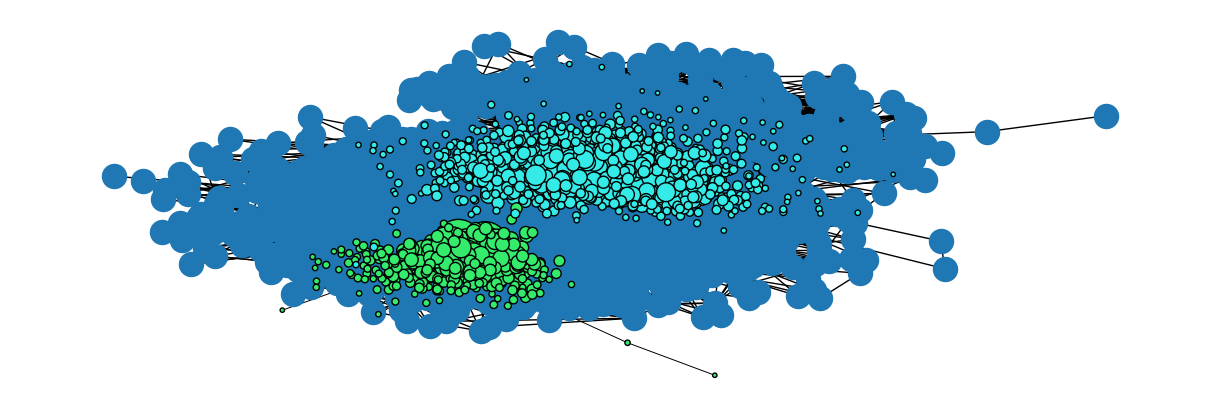

In [100]:
plt.clf()
plt.figure(figsize=(12, 4))
pos = nx.draw_kamada_kawai(undi_largest_cpG)

color_state_map = {"DC": "#34eb6b", "Marvel": "#34ebe8"}  #DC: Green and Marvel: Blue

edge_options = {"width": .7, "alpha": 1, "edge_color": "black"}

degrees = nx.degree(undi_largest_cpG)

nx.draw(undi_largest_cpG, pos
        , node_color = [color_state_map[uni_node[1]['universe']] for uni_node in undi_largest_cpG.nodes(data=True)]
        , node_size = [(degrees[v] + 1) * 5 for v in undi_largest_cpG.nodes()]
        , edgecolors='black', **edge_options)

plt.show()

*Exercise 3:* We can make even better visualisations with `ForceAtlas2` package. (By "better" we mean "more beautiful" of course, **but** better also means more useful in terms of understanding the network. A good visualization that really captures structure in the graph can help you understand the network. )

>1. The [Force Atlas 2 algorithm](https://github.com/bhargavchippada/forceatlas2) helps calculate more aesthetically pleasing positions for the nodes (see what the result looks like below).
>2.You can install the package in conda typing something along the lines of `conda install -c conda-forge fa2` in the terminal. The [github page](https://github.com/bhargavchippada/forceatlas2) explains how to use the package to get coordinates for each node. You can then feed those coordinates to NetworkX (see below).
> * Visualize the network using the [NetworkX draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `universe` attribute (i.e. use different colors for DC and Marvel universe)
>   * Node size should depend on the node *degree*
>   * **Optional**: Edge colour should depend on the `universe` attribute. If an edge connects nodes from Marvel universe assign `color_a`, if the edge connects nodes from DC universe assign `color_b`, in other cases assign `color_c`
> * Play with the force atlas algorithm parameters to obtain a visualization you like. It may look similar to the one below (but not necessarily). 
> * Describe the structure you observe. Can you see that the nodes seperate into two separate clusters? Can you see high-degree nodes? In the plot below, the red nodes seem to split into two sub-clusters: What's going on there?

![Network](https://github.com/SocialComplexityLab/socialgraphs2020/blob/master/files/week5_fa2_a.png?raw=true)

100%|██████████| 2000/2000 [00:15<00:00, 127.04it/s]


BarnesHut Approximation  took  5.47  seconds
Repulsion forces  took  9.16  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.17  seconds
AdjustSpeedAndApplyForces step  took  0.56  seconds


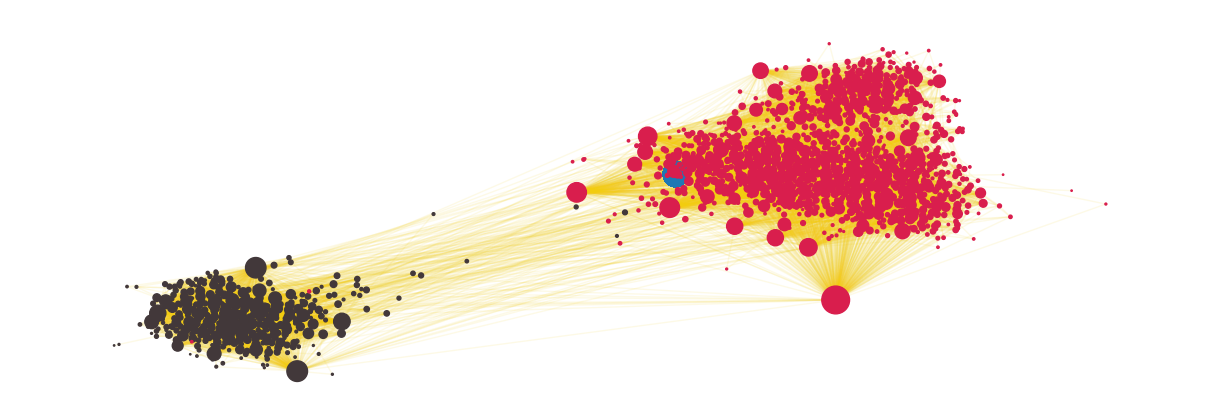

In [115]:
plt.figure(figsize=(12, 4))

color_state_map = {"DC": "#42383a", "Marvel": "#d91e4d"}  #DC: Green and Marvel: Blue

degrees = nx.degree(undi_largest_cpG)

pos = nx.draw_kamada_kawai(undi_largest_cpG)

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=5.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(undi_largest_cpG, pos=pos, iterations=2000)
nx.draw_networkx_nodes(undi_largest_cpG, positions, 
                       node_size=[degrees[v] for v in undi_largest_cpG.nodes()], 
                       label=False, 
                       node_color=[color_state_map[uni_node[1]['universe']] for uni_node in undi_largest_cpG.nodes(data=True)], 
                       alpha=1.0)
nx.draw_networkx_edges(undi_largest_cpG, positions, edge_color="#f2cc0f", alpha=0.1)
plt.axis('off')
plt.show()

*Exercise 4*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

>1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>   * Consider the set of neighbours pointing towards the node found above. 
>   * What is the relation between the characters you identified and their network neighbours? (e.g. do they appear in the same comics?, are they opponents?, etc ...). You don't need to come up with a grand theory of comics here, I just want you to think about how links arise, why the links are there.
>   * Repeat the exercise for the largest out-degree node. 
>   * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia
>5. Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
>6. Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens? 

1. Consider the nodes with highest in-degree in the network.

In [140]:
all_degreeSort = sorted(largest_cpG.in_degree, key=lambda x: x[1], reverse=True)
indegreeKing = all_degreeSort[0]
print(indegreeKing)
print(indegreeKing[0])

('Spider-Man', 394)
Spider-Man


Open the corresponding Wikipedia page.

In [141]:
wiki_path = "https://en.wikipedia.org/wiki/"

source = urlopen(wiki_path + indegreeKing[0]).read()
soup = BeautifulSoup(source, "html.parser")
#print(set([text.parent.name for text in soup.find_all(text=True)])) #print everything configuration in the "soup"

# Extract the plain text content from paragraphs
text = ''
for paragraph in soup.find_all('p'):
    text += paragraph.text

#Drop footnote and "\n" in the paragraph
text = re.sub(r'\[.*?\]+', '', text)
text = text.replace('\n', '')
#print(text)

* Consider the set of neighbours pointing towards the node found above. 
* What is the relation between the characters you identified and their network neighbours? (e.g. do they appear in the same comics?, are they opponents?, etc ...). You don't need to come up with a grand theory of comics here, I just want you to think about how links arise, why the links are there.

In [171]:
list_indegreeKing = list(largest_cpG[indegreeKing[0]])
#print(len(list_indegreeKing))

DC_count = 0
Marvel_count = 0
for y in list_indegreeKing:
    if largest_cpG.nodes[y]['universe'] == "DC":
        DC_count += 1
        print("The opponents: " + y)
    elif largest_cpG.nodes[y]['universe'] == "Marvel":
        Marvel_count += 1

print("Number of the nodes in marvel: " + str(Marvel_count))
print("Number of the nodes in DC: " + str(DC_count))


The opponents: Batman
The opponents: Superman
The opponents: Hawkman
Number of the nodes in marvel: 32
Number of the nodes in DC: 3


* Repeat the exercise for the largest out-degree node. 

In [173]:
all_degreeSort = sorted(largest_cpG.out_degree, key=lambda x: x[1], reverse=True)
outdegreeKing = all_degreeSort[0]
print(all_degreeSort[:5])
print(outdegreeKing)
print(outdegreeKing[0])

[('Betsy_Braddock', 66), ('Kraven_the_Hunter', 62), ('Hellfire_Club_(comics)', 59), ('Cyclops_(Marvel_Comics)', 58), ('Deathstroke', 53)]
('Betsy_Braddock', 66)
Betsy_Braddock


In [174]:
wiki_path = "https://en.wikipedia.org/wiki/"

source = urlopen(wiki_path + outdegreeKing[0]).read()
soup = BeautifulSoup(source, "html.parser")
#print(set([text.parent.name for text in soup.find_all(text=True)])) #print everything configuration in the "soup"

# Extract the plain text content from paragraphs
text = ''
for paragraph in soup.find_all('p'):
    text += paragraph.text

#Drop footnote and "\n" in the paragraph
text = re.sub(r'\[.*?\]+', '', text)
text = text.replace('\n', '')
#print(text)

In [175]:
list_outdegreeKing = list(largest_cpG[outdegreeKing[0]])
#print(len(list_outdegreeKing))

DC_count = 0
Marvel_count = 0
for z in list_outdegreeKing:
    if largest_cpG.nodes[z]['universe'] == "DC":
        DC_count += 1
        print("The opponents: " + z)
    elif largest_cpG.nodes[z]['universe'] == "Marvel":
        Marvel_count += 1

print("Number of the nodes in marvel: " + str(Marvel_count))
print("Number of the nodes in DC: " + str(DC_count))


Number of the nodes in marvel: 66
Number of the nodes in DC: 0


# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

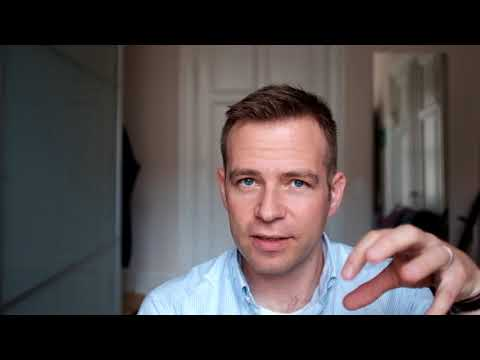

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 5:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

>1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
>    * On top of that, calculate same statistics separately for the network that is spanned only by DC Characters (we call this the DC-network), and only by the Marvel characters (the Marvel-network). How do you interpret the results? 
>2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * A long time ago, a group of scientists analyzed the network spanned by ***all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
>3. Create a scatter plot of the the in- versus out- degree for all characters. Comment on the relation between the two.
>4. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. What is the advantage of using a heatmap over the scatter plot?
>5. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version. Which questions? Can you think of examples when the in/out distinction doesn't matter.
>6. We have one more metric that we did not use. The node-attribute `content lenght`. There are two things we can investigate here.
>   * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>   * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>   * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words

1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
>    * On top of that, calculate same statistics separately for the network that is spanned only by DC Characters (we call this the DC-network), and only by the Marvel characters (the Marvel-network). How do you interpret the results? 

In [180]:
print(largest_cpG.in_degree['Spider-Man'])
print(largest_cpG.out_degree['Spider-Man'])
print(largest_cpG.degree['Spider-Man'])

394
35
429


In [215]:
#In-degree
all_indegree = sorted(largest_cpG.in_degree, key=lambda x: x[1], reverse=True)
all_indegree_nums = list(list(zip(*all_indegree))[1])
aver_indegree = np.average(all_indegree_nums)
median_indegree = np.median(all_indegree_nums)
mode_indegree = max(all_indegree_nums, key=all_indegree_nums.count)
max_indegree = all_indegree_nums[0]
min_indegree = all_indegree_nums[-1]

print("Average of in-degree: " + str(aver_indegree))
print("Median of in-degree: " + str(median_indegree))
print("Mode of in-degree: " + str(mode_indegree))
print("Maximum degree value in in-degree: " + str(max_indegree))
print("Minimum degree value in in-degree: " + str(min_indegree))

print("- - - - - - - - - - - - - - - - - - - - - -")
#Out-degree
all_outdegree = sorted(largest_cpG.out_degree, key=lambda x: x[1], reverse=True)
all_outdegree_nums = list(list(zip(*all_outdegree))[1])
aver_outdegree = np.average(all_outdegree_nums)
median_outdegree = np.median(all_outdegree_nums)
mode_outdegree = max(all_outdegree_nums, key=all_outdegree_nums.count)
max_outdegree = all_outdegree_nums[0]
min_outdegree = all_outdegree_nums[-1]

print("Average of out-degree: " + str(aver_outdegree))
print("Median of out-degree: " + str(median_outdegree))
print("Mode of out-degree: " + str(mode_outdegree))
print("Maximum degree value in out-degree: " + str(max_outdegree))
print("Minimum degree value in out-degree: " + str(min_outdegree))

Average of in-degree: 12.440677966101696
Median of in-degree: 6.0
Mode of in-degree: 2
Maximum degree value in in-degree: 394
Minimum degree value in in-degree: 1
- - - - - - - - - - - - - - - - - - - - - -
Average of out-degree: 12.440677966101696
Median of out-degree: 9.0
Mode of out-degree: 7
Maximum degree value in out-degree: 66
Minimum degree value in out-degree: 1


They have the same average and minimum degree value. Although the in-degree's maximum degree value is much higher than the out-degree one, the out-degree numbers of the median and mode part are higher than the in-degree one.

**DC-network**

* In-degree and Out-degree

In [217]:
selected_nodes = [n for n,att in largest_cpG.nodes(data=True) if att['universe'] == 'DC']
D = largest_cpG.subgraph(selected_nodes).copy()
Dcharac_in = sorted(D.in_degree, key=lambda x: x[1], reverse=True)

all_indegree_nums = list(list(zip(*Dcharac_in))[1])
aver_indegree = np.average(all_indegree_nums)
median_indegree = np.median(all_indegree_nums)
mode_indegree = max(all_indegree_nums, key=all_indegree_nums.count)
max_indegree = all_indegree_nums[0]
min_indegree = all_indegree_nums[-1]

print("Average of in-degree: " + str(aver_indegree))
print("Median of in-degree: " + str(median_indegree))
print("Mode of in-degree: " + str(mode_indegree))
print("Maximum degree value in in-degree: " + str(max_indegree))
print("Minimum degree value in in-degree: " + str(min_indegree))

print("- - - - - - - - - - - - - - - - - - - - - -")
#Out-degree
Dcharac_out = sorted(D.out_degree, key=lambda x: x[1], reverse=True)

all_outdegree_nums = list(list(zip(*Dcharac_out))[1])
aver_outdegree = np.average(all_outdegree_nums)
median_outdegree = np.median(all_outdegree_nums)
mode_outdegree = max(all_outdegree_nums, key=all_outdegree_nums.count)
max_outdegree = all_outdegree_nums[0]
min_outdegree = all_outdegree_nums[-1]

print("Average of out-degree: " + str(aver_outdegree))
print("Median of out-degree: " + str(median_outdegree))
print("Mode of out-degree: " + str(mode_outdegree))
print("Maximum degree value in out-degree: " + str(max_outdegree))
print("Minimum degree value in out-degree: " + str(min_outdegree))


Average of in-degree: 11.740359897172237
Median of in-degree: 5.0
Mode of in-degree: 2
Maximum degree value in in-degree: 203
Minimum degree value in in-degree: 0
- - - - - - - - - - - - - - - - - - - - - -
Average of out-degree: 11.740359897172237
Median of out-degree: 9.0
Mode of out-degree: 7
Maximum degree value in out-degree: 50
Minimum degree value in out-degree: 1


Quite the same situation as the overall one but the minimum degree values are different this time.

**Marvel-network**

* In-degree and Out-degree

In [218]:
selected_nodes = [n for n,att in largest_cpG.nodes(data=True) if att['universe'] == 'Marvel']
M = largest_cpG.subgraph(selected_nodes).copy()
Mcharac_in = sorted(M.in_degree, key=lambda x: x[1], reverse=True)

all_indegree_nums = list(list(zip(*Mcharac_in))[1])
aver_indegree = np.average(all_indegree_nums)
median_indegree = np.median(all_indegree_nums)
mode_indegree = max(all_indegree_nums, key=all_indegree_nums.count)
max_indegree = all_indegree_nums[0]
min_indegree = all_indegree_nums[-1]

print("Average of in-degree: " + str(aver_indegree))
print("Median of in-degree: " + str(median_indegree))
print("Mode of in-degree: " + str(mode_indegree))
print("Maximum degree value in in-degree: " + str(max_indegree))
print("Minimum degree value in in-degree: " + str(min_indegree))

print("- - - - - - - - - - - - - - - - - - - - - -")
#Out-degree
Mcharac_out = sorted(M.out_degree, key=lambda x: x[1], reverse=True)

all_outdegree_nums = list(list(zip(*Mcharac_out))[1])
aver_outdegree = np.average(all_outdegree_nums)
median_outdegree = np.median(all_outdegree_nums)
mode_outdegree = max(all_outdegree_nums, key=all_outdegree_nums.count)
max_outdegree = all_outdegree_nums[0]
min_outdegree = all_outdegree_nums[-1]

print("Average of out-degree: " + str(aver_outdegree))
print("Median of out-degree: " + str(median_outdegree))
print("Mode of out-degree: " + str(mode_outdegree))
print("Maximum degree value in out-degree: " + str(max_outdegree))
print("Minimum degree value in out-degree: " + str(min_outdegree))


Average of in-degree: 12.493554327808472
Median of in-degree: 6.0
Mode of in-degree: 2
Maximum degree value in in-degree: 384
Minimum degree value in in-degree: 0
- - - - - - - - - - - - - - - - - - - - - -
Average of out-degree: 12.493554327808472
Median of out-degree: 9.0
Mode of out-degree: 6
Maximum degree value in out-degree: 66
Minimum degree value in out-degree: 0


The same situation as the ooverall one. Just some parameters have changed.

2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * A long time ago, a group of scientists analyzed the network spanned by ***all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 

In [229]:
all_indegree = sorted(largest_cpG.in_degree, key=lambda x: x[1], reverse=True)
all_indegree_nums = list(list(zip(*all_indegree))[1])
all_outdegree = sorted(largest_cpG.out_degree, key=lambda x: x[1], reverse=True)
all_outdegree_nums = list(list(zip(*all_outdegree))[1])
all_degree = sorted(largest_cpG.degree, key=lambda x: x[1], reverse=True)
all_degree_nums = list(list(zip(*all_degree))[1])

results_in = powerlaw.Fit(all_indegree_nums).alpha
print(results_in)
results_out = powerlaw.Fit(all_outdegree_nums).alpha
print(results_out)
results = powerlaw.Fit(all_degree_nums).alpha
print(results)

Calculating best minimal value for power law fit
2.804403279101041%
Calculating best minimal value for power law fit
6.076667663875033%
Calculating best minimal value for power law fit
3.129228761033157%


**In-degree Distribution**

Text(0.5, 1.0, 'In-Degree distribution (log-log)')

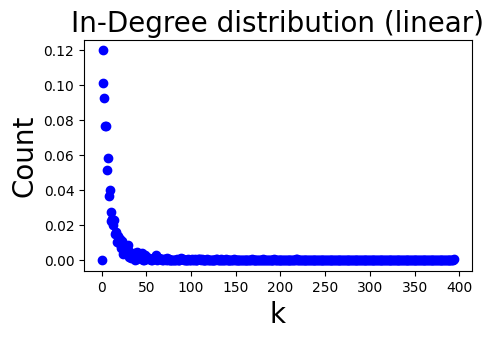

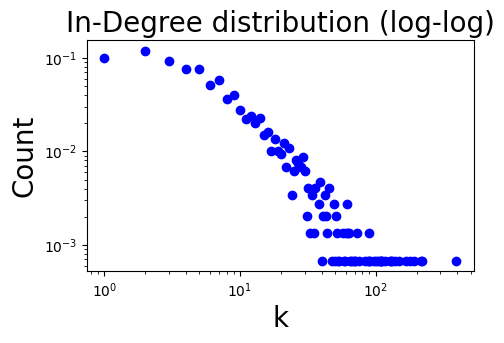

In [242]:

def degree_distribution(degs):
    maxdeg = degs[0]
    mindeg = degs[-1]
    
    kvalues= np.arange(0,maxdeg+1) # possible values of k
    count = np.zeros(maxdeg+1) # P(k)
    for k in degs:
        count[k] = count[k] + 1
    count = count/sum(count) # the sum of the elements of count(Pk) must to be equal to one
    return kvalues,count

all_indegree = sorted(largest_cpG.in_degree, key=lambda x: x[1], reverse=True)
all_indegree_nums = list(list(zip(*all_indegree))[1])
ks_in, count_in = degree_distribution(all_indegree_nums)

plt.figure(figsize=(5,3))
plt.plot(ks_in,count_in,'bo')
plt.xlabel("k", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("In-Degree distribution (linear)", fontsize=20)

plt.figure(figsize=(5,3))
plt.loglog(ks_in,count_in,'bo')
plt.xlabel("k", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("In-Degree distribution (log-log)", fontsize=20)

**Out-degree Distribution**

Text(0.5, 1.0, 'Out-Degree distribution (log-log)')

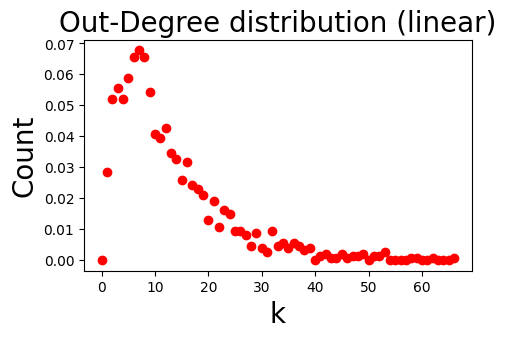

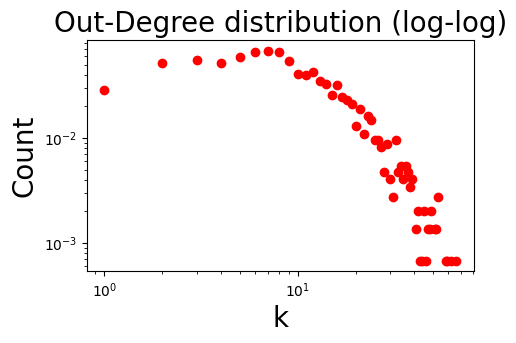

In [243]:
all_outdegree = sorted(largest_cpG.out_degree, key=lambda x: x[1], reverse=True)
all_outdegree_nums = list(list(zip(*all_outdegree))[1])
ks_out, count_out = degree_distribution(all_outdegree_nums)

plt.figure(figsize=(5,3))
plt.plot(ks_out,count_out,'ro')
plt.xlabel("k", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Out-Degree distribution (linear)", fontsize=20)

plt.figure(figsize=(5,3))
plt.loglog(ks_out,count_out,'ro')
plt.xlabel("k", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Out-Degree distribution (log-log)", fontsize=20)

* Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. What is the advantage of using a heatmap over the scatter plot?

**In-Degree**

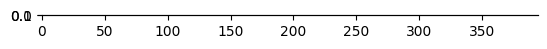

In [248]:
heatmap, xedges, yedges = np.histogram2d(ks_in, count_in, bins=(512, 384))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

**Out-Degree**

*Exercise 6:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. Meanwhile, **for this exercise use either the DC or Marvel Network alone (i.e. only a single universe). This it will help you to see the differences).**
>1. Find the 5 most central characters according to degree centrality. 
>   * Repeat Exercise 2 or 3 from part A above for your new sub-network (depending on which visualization method you liked the most), but with our new network.
>1. Find the 5 most central characters according to betweenness centrality. 
>   * Repeat Exercise 2 or 3 once again. However, this time use *betweenness centrality* to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
>2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>   * Repeat Exercise 2 or 3 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>   * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
>3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>    * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
>4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
>4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `content length` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?. Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
>5. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>   * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

---

> * **Optional** (but cool). What about betweenness centrality in the full network? Create a visualization of the network using Force Atlas 2, where you set the size of nodes to scale according to their betweenness centrality. Describe in your own words what you learn from that plot.

*Exercise 7*: Does a universe of a character play a role in the network as a whole? Now, let us explore if and how the universes shape the network (use full network).

**Note**. We explore this question using a general framework where we shuffle properties of nodes to create ensembles of networks to which we can compare our observed network. This is a version of the [permutation test](https://en.wikipedia.org/wiki/Permutation_test); don't worry if this all sounds fancy, we will guide you through all the steps..

>1. Compute the average node centrality for Marvel and DC characters respectively (choose your favourite centrality measure), let's call these $C_\textrm{marvel}$ and $C_\textrm{DC}$, where $C = \sum_{n  \in \textrm{universe}} c_n$ and the centrality of node $n$ is $c_{n}$. Which universe has the more central characters on average? (These are the real-world values you will be comparing to the shuffeled/permuted networks below.)
>2. Now we build a single comparison graph: Create a version of the full graph $R$, where the association between nodes and universes is shuffled (so in $R$ it is arbitrary which universe a character belongs to, but we maintain the same number of Marvel/DC characters as in the original graph). Compute the average centrality of DC and Marvel nodes for the $R$ graph, we can call these $C_\textrm{marvel}(R)$ and $C_\textrm{DC}(R)$. (This is one pair of values to compare to the real values $C_\textrm{marvel}$ and $C_\textrm{DC}$).
>   * **Hint**: The way I usually create random lables is by using either [`random.shuffle`](https://docs.python.org/3/library/random.html#random.shuffle) or [`numpy.random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html).
>3. Repeat the shuffling process above 1000 times (resulting in 1000 graphs $R_1 \ldots R_{1000}$) and plot two histograms, one histogram with values $\{C_\textrm{marvel}(R_1) \ldots C_\textrm{marvel}(R_{1000})\}$, which you can compare to $C_\textrm{marvel}$ and create the same plot for the DC characters based on the DC networks. The cool thing here is now you can compare your value from the real network to a *distribution* of averages from the ensemble of shuffled networks - you can answer questions along the lines of 'are the real values typical, as in situation **A** in the figure below, or rare as in situation **B** below'). Now it's your turn
>4. What is going on with the average centralities of the Marvel / DC characters relative to the ensemble of networks where universe assignments have been shuffled? Think about your results, what could be possible explanations for what you observe?

![a visual explanation](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/main/files/permutation.jpg)